<a href="https://colab.research.google.com/github/Ayush310803/ViT/blob/main/Deeplabv3%2B_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

os.environ["KAGGLE_CONFIG_DIR"] = "/content"
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

dataset_zip = "/content/people-clothing-segmentation.zip"
extract_path = "/content/dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully.")
!ls /content/dataset

image_dir = "/content/dataset/jpeg_images/IMAGES"
mask_dir = "/content/dataset/jpeg_masks/MASKS"
label_path = "/content/dataset/labels.csv"

Dataset URL: https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation
License(s): CC0-1.0
 97% 597M/616M [00:08<00:00, 65.2MB/s]
100% 616M/616M [00:08<00:00, 72.8MB/s]
✅ Dataset extracted successfully.
 jpeg_images   jpeg_masks  'labels (1).csv'   labels.csv   png_images   png_masks


In [2]:
!pip install keras opencv-python matplotlib
!pip install --upgrade tensorflow==2.18.0


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define paths
image_dir = "/content/dataset/jpeg_images/IMAGES"
mask_dir = "/content/dataset/jpeg_masks/MASKS"
label_path = "/content/dataset/labels.csv"

# Load image and mask paths
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir)]

# Sort paths to ensure alignment
image_paths.sort()
mask_paths.sort()

# Load and preprocess images and masks
images = np.array([cv2.resize(cv2.imread(img_path, cv2.IMREAD_COLOR), (256, 256)) for img_path in image_paths])
masks = np.array([cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), (256, 256)) for mask_path in mask_paths])

# Normalize images
images = images / 255.0

# Check unique values in masks
unique_values = np.unique(masks)
print("Unique values in masks:", unique_values)
print("Number of unique classes:", len(unique_values))

# Normalize masks to ensure labels are in the range [0, num_classes)
label_encoder = LabelEncoder()
masks_flat = masks.flatten()
masks_encoded = label_encoder.fit_transform(masks_flat)
masks = masks_encoded.reshape(masks.shape)

# Verify the new unique values
unique_values = np.unique(masks)
print("Unique values after encoding:", unique_values)

# Split dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Define the DeepLabV3+ model
def build_deeplabv3_plus(input_shape, num_classes):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Encoder (ResNet50)
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    x = resnet50.get_layer('conv4_block6_out').output

    # Atrous Spatial Pyramid Pooling (ASPP)
    # Branch 1: 1x1 convolution
    b1 = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)

    # Branch 2: 3x3 convolution, rate=6
    b2 = layers.Conv2D(256, 3, padding='same', dilation_rate=6, use_bias=False)(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)

    # Branch 3: 3x3 convolution, rate=12
    b3 = layers.Conv2D(256, 3, padding='same', dilation_rate=12, use_bias=False)(x)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.Activation('relu')(b3)

    # Branch 4: 3x3 convolution, rate=18
    b4 = layers.Conv2D(256, 3, padding='same', dilation_rate=18, use_bias=False)(x)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.Activation('relu')(b4)

    # Concatenate branches
    x = layers.concatenate([b1, b2, b3, b4])

    # Decoder
    x = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Upsample to match input resolution
    x = layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(x)

    # Output layer (no activation for sparse categorical cross-entropy)
    outputs = layers.Conv2D(num_classes, 1)(x)  # No activation

    # Model
    model = Model(inputs, outputs)
    return model

# Define input shape and number of classes
input_shape = (256, 256, 3)  # Input resolution
num_classes = len(unique_values)  # Updated based on the actual number of classes

# Build the model
model = build_deeplabv3_plus(input_shape, num_classes)

# Compile the model with sparse categorical cross-entropy
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Define batch size
batch_size = 8

# Create a data generator
def data_generator(images, masks, batch_size):
    num_samples = len(images)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)  # Shuffle indices for randomness

        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]

            batch_images = images[batch_indices]
            batch_masks = masks[batch_indices]

            yield batch_images, batch_masks

# Create data generators
train_generator = data_generator(X_train, y_train, batch_size)
val_generator = data_generator(X_test, y_test, batch_size)

# Define steps per epoch
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=10
)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator, steps=validation_steps)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Save the model
model.save('deeplabv3_plus_segmentation_model.h5')

Unique values in masks: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Number of unique classes: 64
Unique values after encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 16,212,928 (61.85 MB)

 Trainable params: 16,179,776 (61.72 MB)

 Non-trainable params: 33,152 (129.50 KB)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2503s 25s/step - accuracy: 0.7502 - loss: 1.2397 - val_accuracy: 0.2459 - val_loss: 4.7607
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2501s 25s/step - accuracy: 0.8439 - loss: 0.6092 - val_accuracy: 0.7605 - val_loss: 1.3641
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2473s 25s/step - accuracy: 0.8553 - loss: 0.5494 - val_accuracy: 0.7617 - val_loss: 1.5276
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2471s 25s/step - accuracy: 0.8695 - loss: 0.4997 - val_accuracy: 0.7610 - val_loss: 1.4276
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2453s 25s/step - accuracy: 0.8799 - loss: 0.4596 - val_accuracy: 0.7605 - val_loss: 1.7992
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2482s 25s/step - accuracy: 0.8869 - loss: 0.4355 - val_accuracy: 0.7695 - val_loss: 1.2682
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2483s 25s/step - accuracy: 0.9019 - loss: 0.3886 - val_accuracy: 0.7680 - val_loss: 1.3876
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2496s 25s/step - accuracy: 0.9148 - loss: 0

Validation Loss: 0.7996595501899719
Validation Accuracy: 0.8251187801361084


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


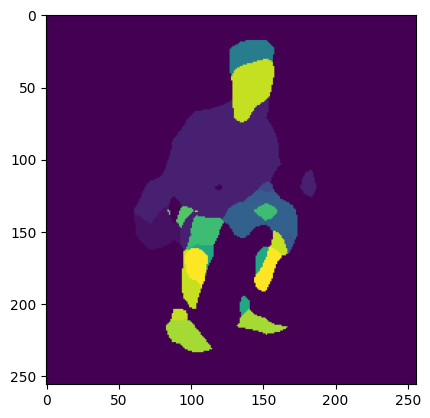

In [8]:
# prompt: test on a custom image

import cv2
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('deeplabv3_plus_segmentation_model.h5')

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Path to your custom image
image_path = "/content/Bodyweight-Squat.jpg" #@param {type:"string"}

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Process predictions (e.g., convert to class labels)
predicted_mask = np.argmax(predictions[0], axis=-1)

# Display or save the predicted mask
import matplotlib.pyplot as plt
plt.imshow(predicted_mask)
plt.show()


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
model.save('/content/drive/My Drive/deeplabv3_plus_segmentation_model.h5')